<h4><b>Importing necessary libraries and connecting to the database</b></h4>

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
# Connect to SQLite database
conn = sqlite3.connect("../saas.db")

<h4><b>Checking tables in the database</b></h4>

In [2]:
pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)

,name
0,accounts_staging
1,subscriptions_staging
2,feature_usage_staging
3,support_tickets_staging
4,churn_staging
5,accounts
6,subscriptions
7,feature_usage
8,support_ticket
9,churn


<h4><b>Loading necessary tables and views</b></h4>

In [3]:
accounts=pd.read_sql("SELECT * FROM accounts",conn)
accounts.head()
monthly_churn = pd.read_sql("SELECT * FROM monthly_churn_rate",conn)
monthly_churn.head()

,month,churned_accounts,active_accounts,monthly_churn_rate
0,2023-02,0,17,0.0000
1,2023-03,5,35,0.1429
2,2023-04,3,53,0.0566
3,2023-05,3,67,0.0448
4,2023-06,5,90,0.0556


<h4><b>Calculating Overall Churn Rate</b></h4>

In [4]:
accounts["churn_flag"]=accounts["churn_flag"]=='True'
overall_churn_rate=(accounts["churn_flag"]).mean()*100 #churn_flag is boolean to check if account has ever been churned
print("Overall churn rate =",overall_churn_rate,"%")

Overall churn rate = 22.0 %


<h4><b>Plotting monthly churn rate over time</b></h4>

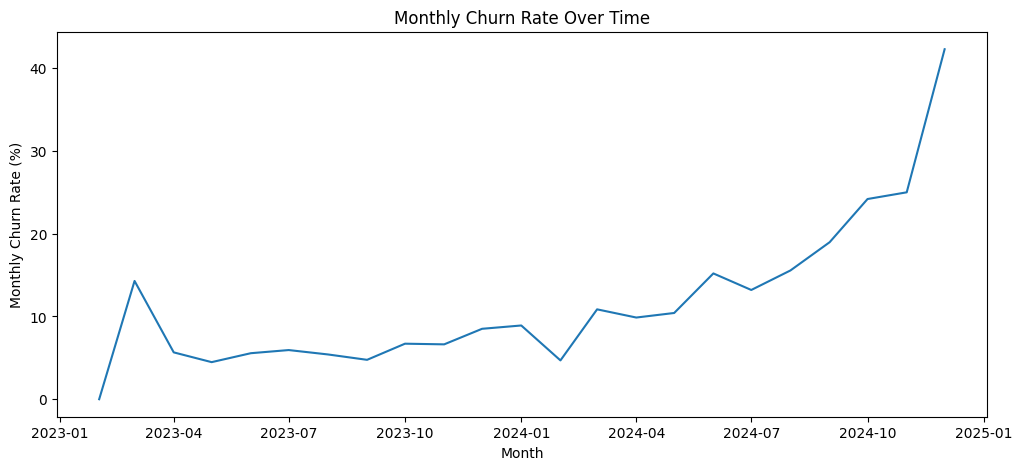

In [5]:
monthly_churn["month"]=pd.to_datetime(monthly_churn["month"]) #converting month column from string to date-time format
plt.figure(figsize=(12, 5))
plt.plot(monthly_churn["month"],(monthly_churn["monthly_churn_rate"]*100))
plt.xlabel("Month")
plt.ylabel("Monthly Churn Rate (%)")
plt.title("Monthly Churn Rate Over Time")
plt.show()

<h4>Monthly churn was relatively stable through 2023, followed by a sharp increase in 2024, suggesting a structural change rather than random noise.</h4>

<h4><b>Calculating overall churn for different plan-tier, Trial vs Paid Accounts</b></h4>

In [6]:
print(accounts.groupby("plan_tier")["churn_flag"].mean() * 100)
print(accounts.groupby("is_trial")["churn_flag"].mean() * 100)


plan_tier
Basic         22.023810
Enterprise    22.077922
Pro           21.910112
Name: churn_flag, dtype: float64
is_trial
False    21.091811
True     25.773196
Name: churn_flag, dtype: float64


<h4><b>Calculating overall churn by Country, Industry</b></h4>

In [7]:

print(accounts.groupby("industry")["churn_flag"].mean() * 100)
print(accounts.groupby("country")["churn_flag"].mean() * 100)

industry
Cybersecurity    16.000000
DevTools         30.973451
EdTech           16.455696
FinTech          22.321429
HealthTech       21.875000
Name: churn_flag, dtype: float64
country
AU    12.500000
CA    17.391304
DE    32.000000
FR    22.727273
IN    20.408163
UK    18.965517
US    23.367698
Name: churn_flag, dtype: float64


<h5>Initial segmentation by plan tier did not reveal materially different churn patterns, suggesting it is not a strong basis for cohort construction.
In contrast, trial status.DevTools industry, Germany(DE) country shows meaningful differences in early churn behavior, indicating potential reasons.</h5>

<h4><b>Plotting Active Accounts Per Month and Number of Churn Events Per Month</b></h4>

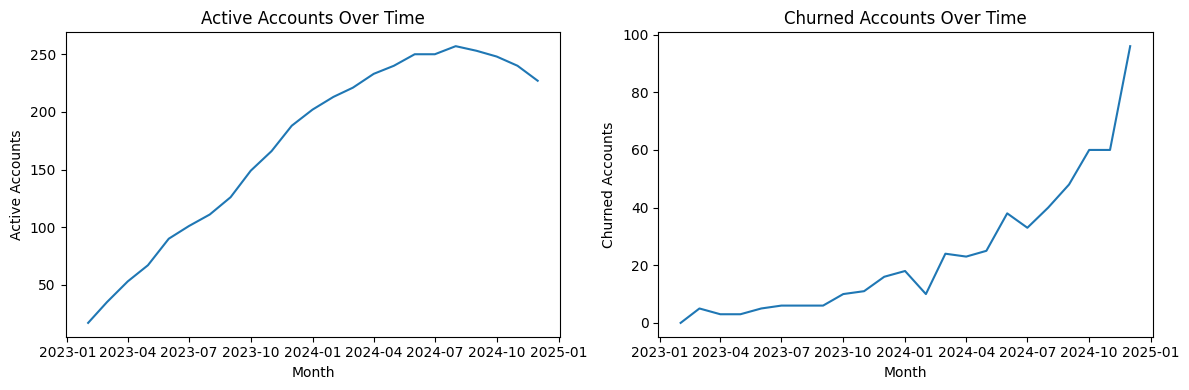

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# First plot
axes[0].plot(monthly_churn["month"], monthly_churn["active_accounts"])
axes[0].set_title("Active Accounts Over Time")
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Active Accounts")

# Second plot
axes[1].plot(monthly_churn["month"],monthly_churn["churned_accounts"])
axes[1].set_title("Churned Accounts Over Time")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Churned Accounts")

plt.tight_layout()
plt.show()

<h5>While the active account base grew steadily through 2023 and early 2024, growth stalled and reversed around mid-2024. At the same time, churned accounts began increasing more rapidly, particularly in the second half of 2024.</h5>

<h4><b>Calculating Trial Percentage and Devtool Signup Percentage by Month </b></h4>

In [9]:
accounts["signup_date"] = pd.to_datetime(accounts["signup_date"])
accounts["signup_month"] = accounts["signup_date"].dt.to_period("M")
accounts["is_trial"]=accounts["is_trial"]=='True'
trial_pct_by_month = (accounts.groupby("signup_month")["is_trial"].mean().mul(100).reset_index(name="trial_pct"))
trial_pct_by_month["signup_month"] = trial_pct_by_month["signup_month"].dt.to_timestamp()
devtools_pct_by_month = (
    accounts
    .groupby("signup_month")["industry"]
    .apply(lambda x: (x == "DevTools").mean() * 100)
    .reset_index(name="devtools_pct")
)
devtools_pct_by_month["signup_month"] = devtools_pct_by_month["signup_month"].dt.to_timestamp()


<h4><b>Plotting Trial % and DevTools Signup Percentage (3-month rolling average)<b></h4>

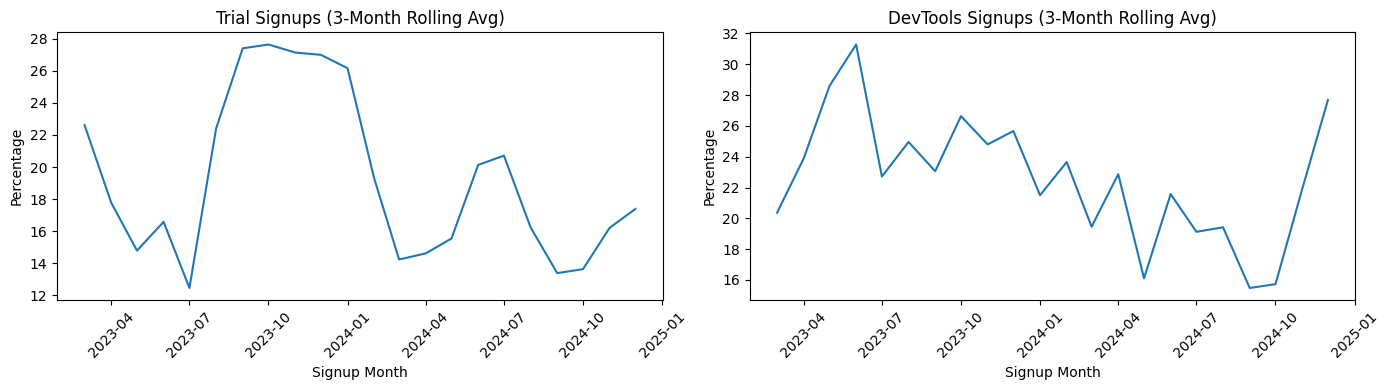

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Left subplot - Trial % (3-month rolling)
axes[0].plot(
    trial_pct_by_month["signup_month"],
    trial_pct_by_month["trial_pct"].rolling(3).mean()
)
axes[0].set_title("Trial Signups (3-Month Rolling Avg)")
axes[0].set_xlabel("Signup Month")
axes[0].set_ylabel("Percentage")
axes[0].tick_params(axis="x", rotation=45)

# Right subplot - DevTools % (3-month rolling)
axes[1].plot(
    devtools_pct_by_month["signup_month"],
    devtools_pct_by_month["devtools_pct"].rolling(3).mean()
)
axes[1].set_title("DevTools Signups (3-Month Rolling Avg)")
axes[1].set_xlabel("Signup Month")
axes[1].set_ylabel("Percentage")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


<h5>Rolling-average analysis of trial and DevTools signup shares shows no sustained shift in acquisition mix preceding the churn spike. This suggests the increase in churn is driven by changes in retention dynamics rather than customer composition.</h5>

## EDA Summary

- Overall account-level churn is approximately **22%**, indicating a meaningful retention challenge over the observed period.

- Monthly churn remained relatively stable throughout **2023**, but began to **increase sharply in mid-2024**, reaching unusually high levels compared to historical norms.

- The churn acceleration coincides with a **slowdown and subsequent decline in the active account base**, alongside a visible rise in the absolute number of churn events.

- High-level segmentation across **plan tier, industry, country, and trial status** does not explain the **timing or magnitude** of the churn spike.

- Rolling-average analysis shows **no meaningful change** in acquisition mix (trial users or DevTools signups) preceding the churn increase.

## EDA Conclusion

The observed churn spike is **not driven by changes in customer mix or static segmentation**.  
Instead, the patterns point to a change in how customers retain over time, motivating a **lifecycle-based, time-focused cohort analysis** to understand when churn risk is highest.